In [1]:
import time
from threading import Thread

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from tqdm.auto import trange

from ensae_3a_gadmm.gadmm import display_df_log, gadmm_head_method, gadmm_tail_method
from ensae_3a_gadmm.logistic_regression import f

t = time.time()

## Generation of synthetic data

In [2]:
data, y = make_classification(
    n_samples=10_000, n_features=40, n_redundant=0, n_informative=15
)

In [3]:
# StandardScaler : mean of 0 and std of 1
scaled_data = StandardScaler().fit_transform(data)

pca = PCA(2)
pca_data = pca.fit_transform(scaled_data)
pca_data.shape

(10000, 2)

In [4]:
pca_df = pd.DataFrame(data=pca_data, columns=["PC1", "PC2"])
pca_df["y"] = y
pca_df

,PC1,PC2,y
0,2.532859,1.438573,1
1,0.070669,-0.835737,0
2,-1.282659,-2.107507,1
3,3.340645,-0.490886,0
4,1.549503,-0.926458,1
...,...,...,...
9995,-0.066081,0.342266,1
9996,0.699809,-1.832258,1
9997,-0.782733,0.010291,0
9998,-1.172666,1.237326,0


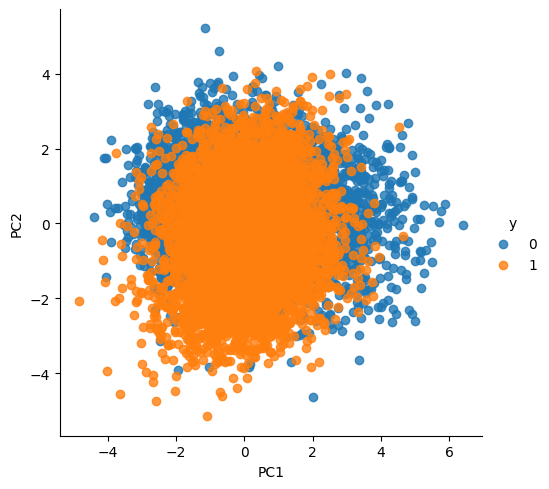

In [5]:
sns.lmplot(x="PC1", y="PC2", data=pca_df, hue="y", fit_reg=False, legend=True)

In [6]:
# Adding an intercept
temp_data = np.ones((data.shape[0], data.shape[1] + 1))
temp_data[:, 1:] = scaled_data
data = temp_data
data.shape

(10000, 41)

In [7]:
d = data.shape[1]
d

41

## Logistic Regression

In [8]:
rho = 1

In [9]:
clf = LogisticRegression(
    penalty="l2", C=rho, fit_intercept=False, solver="liblinear"
).fit(data, y)
y_pred = clf.predict(data)
y_pred_proba = clf.predict_proba(data)
clf.score(data, y)  # compute accuracy

0.8397

In [10]:
opt_theta = clf.coef_
opt_theta

array([[ 7.12766594e-03, -1.85285491e-01, -3.03357174e-02,
        -1.83437223e-02, -3.54766004e-02,  1.63666235e-02,
        -5.24342804e-04, -1.53254719e-02, -1.85645995e-02,
        -8.07686667e-01, -3.99540940e-02,  3.43716967e-01,
         1.20956998e+00, -1.33020348e-02, -2.69813758e-02,
         2.33272729e-02, -3.21729020e-02,  4.19799119e-03,
         3.45122170e-02,  4.55385307e-01,  1.17482123e+00,
         6.45570419e-01, -4.04281277e-02, -3.77066017e-01,
         1.68474163e-02, -1.47322854e-02, -1.06264019e-02,
        -1.34963696e+00,  3.84656221e-02, -8.46159398e-03,
        -1.91270181e-02, -7.85535040e-02,  2.55694787e-02,
        -6.21156247e-03, -2.58447213e-02,  3.43081539e-02,
        -2.34733333e-01, -6.57903132e-03, -5.31824293e-01,
         7.34552390e-03,  7.32171001e-01]])

In [11]:
loss = log_loss(y, y_pred_proba, labels=[0, 1])
loss

0.36831899725507555

## GADMM not parallelized

In [12]:
K = 200  # number of iterations
M = 4  # number of workers
rho = 1

split_data = np.array_split(data, M)

In [13]:
len(split_data)

4

In [14]:
split_data[0].shape

(2500, 41)

In [15]:
split_y = np.array_split(y, M)

In [16]:
len(split_y)

4

In [17]:
split_y[0].shape

(2500,)

In [18]:
f(opt_theta, data, y)

0.3683189972550755

On a la même loss qu'avec sklearn, tout va bien !

---



In [19]:
# Initialisation
Theta = np.zeros((M, d))
Lamb = np.zeros((M, d))

# Iterative procedure
df_log = []

t1 = time.time()
for k in trange(K):
    # Step 1 : head workers
    for n in range(M):
        if n % 2 == 0:
            gadmm_head_method(
                sample_data=split_data[n],
                sample_y=split_y[n],
                lamb=Lamb,
                theta=Theta,
                m=M,
                n=n,
                rho=rho,
            )

    # Step 2 : tail workers
    for n in range(M):
        if n % 2 == 1:
            gadmm_tail_method(
                sample_data=split_data[n],
                sample_y=split_y[n],
                lamb=Lamb,
                theta=Theta,
                m=M,
                n=n,
                rho=rho,
            )

    # Step 3 : Update lambda
    for n in range(M - 1):
        Lamb[n] = Lamb[n] + rho * (Theta[n] - Theta[n + 1])

    for n in range(M):
        df_log.append(
            {
                "iteration": k,
                "worker": n,
                "theta diff norm": np.linalg.norm(Theta[n] - opt_theta),
                "loss": f(Theta[n], data, y),
            }
        )

df_log = pd.DataFrame(df_log)

print(f"Temps : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t1))}")

  0%|          | 0/200 [00:00<?, ?it/s]

Temps : 00:06:15


In [20]:
Theta[0]

array([ 7.14736441e-03, -1.86141606e-01, -3.04924264e-02, -1.84137353e-02,
       -3.55327934e-02,  1.64201048e-02, -5.04554512e-04, -1.53361740e-02,
       -1.85883698e-02, -8.09923157e-01, -4.00964451e-02,  3.44226233e-01,
        1.21330456e+00, -1.33445366e-02, -2.70747007e-02,  2.32612055e-02,
       -3.22777328e-02,  4.18391010e-03,  3.46210061e-02,  4.56979811e-01,
        1.17834760e+00,  6.47252954e-01, -4.06087703e-02, -3.77860371e-01,
        1.69250990e-02, -1.47561032e-02, -1.05745600e-02, -1.35291548e+00,
        3.85869654e-02, -8.42485735e-03, -1.91082077e-02, -7.87896226e-02,
        2.56254837e-02, -6.13755645e-03, -2.59291582e-02,  3.44136407e-02,
       -2.34981799e-01, -6.57515123e-03, -5.33368728e-01,  7.43383234e-03,
        7.34219514e-01])

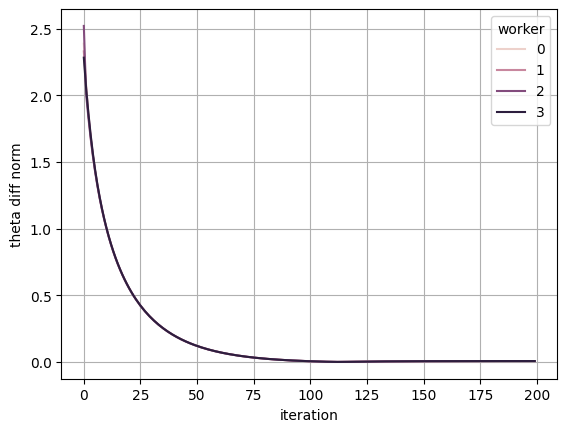

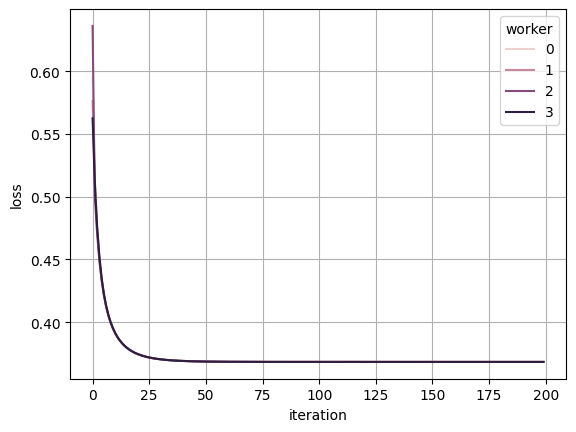

,worker,theta diff norm,loss
0,0,0.007484,0.368318
1,1,0.007482,0.368318
2,2,0.007480,0.368318
3,3,0.007476,0.368318


In [21]:
display_df_log(df_log, data, y, M, Theta, opt_theta)

## Multithreading

In [22]:
# Initialisation
Theta = np.zeros((M, d))
Lamb = np.zeros((M, d))

# Iterative procedure
df_log = []

t1 = time.time()
for k in trange(K):
    # Step 1 : head workers
    threads = []
    for n in range(M):
        if n % 2 == 0:
            thread = Thread(
                target=gadmm_head_method,
                args=(split_data[n], split_y[n], Lamb, Theta, M, n, rho),
            )
            threads.append(thread)
            thread.start()

    for thread in threads:
        thread.join()

    # Step 2 : tail workers
    threads = []
    for n in range(M):
        if n % 2 == 1:
            thread = Thread(
                target=gadmm_tail_method,
                args=(split_data[n], split_y[n], Lamb, Theta, M, n, rho),
            )
            threads.append(thread)
            thread.start()

    for thread in threads:
        thread.join()

    # Step 3 : Update lambda
    for n in range(M - 1):
        Lamb[n] = Lamb[n] + rho * (Theta[n] - Theta[n + 1])

    for n in range(M):
        df_log.append(
            {
                "iteration": k,
                "worker": n,
                "theta diff norm": np.linalg.norm(Theta[n] - opt_theta),
                "loss": f(Theta[n], data, y),
            }
        )

df_log = pd.DataFrame(df_log)

print(f"Temps : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t1))}")

  0%|          | 0/200 [00:00<?, ?it/s]

Temps : 00:08:28


In [23]:
Theta[0]

array([ 7.14736441e-03, -1.86141606e-01, -3.04924264e-02, -1.84137353e-02,
       -3.55327934e-02,  1.64201048e-02, -5.04554512e-04, -1.53361740e-02,
       -1.85883698e-02, -8.09923157e-01, -4.00964451e-02,  3.44226233e-01,
        1.21330456e+00, -1.33445366e-02, -2.70747007e-02,  2.32612055e-02,
       -3.22777328e-02,  4.18391010e-03,  3.46210061e-02,  4.56979811e-01,
        1.17834760e+00,  6.47252954e-01, -4.06087703e-02, -3.77860371e-01,
        1.69250990e-02, -1.47561032e-02, -1.05745600e-02, -1.35291548e+00,
        3.85869654e-02, -8.42485735e-03, -1.91082077e-02, -7.87896226e-02,
        2.56254837e-02, -6.13755645e-03, -2.59291582e-02,  3.44136407e-02,
       -2.34981799e-01, -6.57515123e-03, -5.33368728e-01,  7.43383234e-03,
        7.34219514e-01])

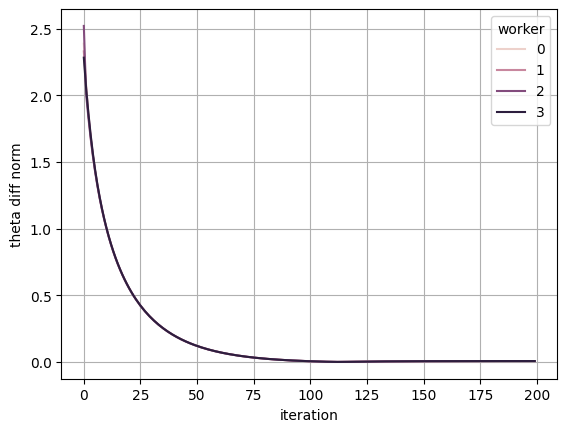

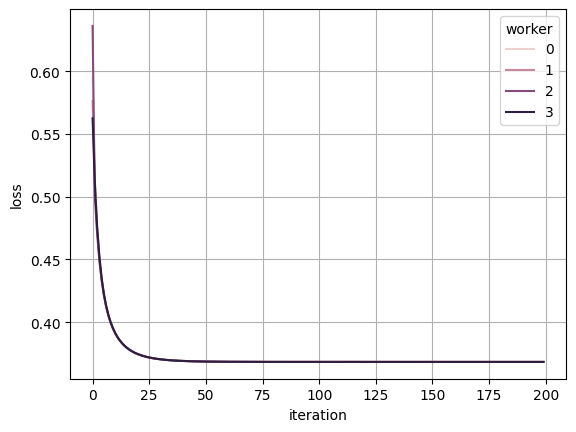

,worker,theta diff norm,loss
0,0,0.007484,0.368318
1,1,0.007482,0.368318
2,2,0.007480,0.368318
3,3,0.007476,0.368318


In [24]:
display_df_log(df_log, data, y, M, Theta, opt_theta)

In [25]:
print(
    f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}"
)

Temps d'exécution total : 00:14:50
